In [7]:
# Basics
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
import cv2
import copy
# Adding noise
from skimage.util import random_noise
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# For CNN
import torch.nn as nn
import torch.nn.functional as F

# For Loss Func. And Optimization
import torch.optim as optim

# For Visual Representation
import matplotlib.pyplot as plt

# In case defined class doesn't work, create new dataset from this
from torchvision.datasets import ImageFolder as img_fold

print("Success")

Success


In [112]:
TRAIN_NOISE = True
TEST_NOISE = False
BATCH_SIZE = 4
NUM_CLASSES = 10
EPOCHS = 5

if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    print("")
# normalizer
transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Available



In [71]:
# Setting root directory for training data
trainroot = "./CNN_Dataset/Level 1"
testroot = "./Noiseimg/test"
# Using ImageFolder to designate and transform our entire dataset (determine if necessary to transform here and in dataloaders)
trainset = img_fold(root=trainroot, transform=transformer)
testset = img_fold(root=testroot, transform=transformer)

In [72]:
# Image Categories
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

# grabbing labels
class_names = trainset.classes
print('Labels: ',class_names)
print('Trainset Length: ', len(trainset))
print('Testset Length: ', len(testset))

Labels:  ['bird', 'car', 'cat', 'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck']
Trainset Length:  5000
Testset Length:  101


In [27]:
# Storing tensors for images and labels
img, label = trainset[0][0], trainset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.9529, -0.8118, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.8824, -0.8667, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.6863, -0.3804,  0.0824,  ..., -0.8745, -1.0000, -0.8588],
         [-0.9922, -0.9294, -1.0000,  ..., -0.5608, -1.0000, -1.0000],
         [-0.6706, -0.6471, -1.0000,  ..., -1.0000, -0.7647, -0.7647]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -0.9216, -0.2627,  ..., -0.9373, -1.0000, -1.0000],
         [-1.0000, -0.9216, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9843, -0.9608, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.

In [73]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

testloader =torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE,
                                            shuffle=True, num_workers=2)

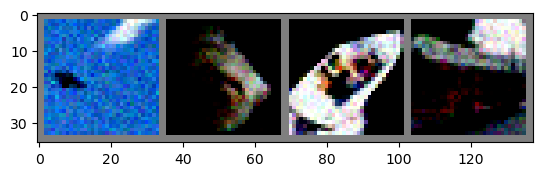

plane dog   ship  truck


In [74]:
# Show image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Randomly selected training img
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [75]:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([4])


In [133]:
# Training Function
def train_model(model, trainloader, criterion, optimizer, device, epochs):
    
    """
    Train the model on the training data.

    Args:
        model (nn.Module): The neural network model.
        trainloader (DataLoader): DataLoader for the training dataset.
        criterion: The loss criterion.
        optimizer: The optimization algorithm.
        device: The device to which the model and data should be moved (e.g., "cuda" or "cpu").
        epochs (int): Number of epochs for training.
    """
    
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader):.3f}, Training Accuracy: {100 * train_accuracy:.2f}%')

    print("Training Complete")
    
# Test Function
def test_model(model, model_name, testloader, device):
    
    """
    Test the model on the entire dataset and store statistics.

    Args:
        model (nn.Module): The neural network model.
        model_name: Name of the neural network model. Used in storing statistics
        testloader (DataLoader): DataLoader for the test dataset.
        device: The device to which the model and data should be moved (e.g., "cuda" or "cpu").

    """
    model.to(device)
    model.eval()
    
    correct = 0 
    total = 0
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Pick class with highest similarity score
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n')
    

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        
    # store statistics
    write_accuracy_to_file(f'{model_name}_accuracy.txt', model_name, correct, total, correct_pred, total_pred, EPOCHS)
    

def write_accuracy_to_file(filename, model_name, correct, total, correct_pred, total_pred, epochs):

    """
    Store model statistics. Designed to be called within test_model function
    """
    # Open the specified text file in write mode
    with open(filename, 'w') as file:
        # Write overall accuracy to the file
        file.write(f'Model: {model_name}\n\n')
        file.write(f'Total Epochs: {epochs}\n\n')
        file.write(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')

        # Write accuracy for each class to the file
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            file.write(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %\n')
            
def save_model(model, name):
    PATH = fr"./Models/{name}"
    torch.save(model, PATH)

In [100]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Dropout Layers
        self.dropout1 = nn.Dropout(0.5)  

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x

In [101]:
# Creating new models
model_train_level_1 = Net()
model_train_val_level_1 = Net()
model_train_vc_level_1 = Net()

# Copying weights of old models to retrain
model_train_level_1.load_state_dict(torch.load('./Models/cifar_net.pth'))
model_train_val_level_1.load_state_dict(torch.load('./Models/cifar_net_Validation.pth'))
model_train_vc_level_1.load_state_dict(torch.load('./Models/cifar_net_kfold.pth'))

<All keys matched successfully>

In [102]:
# Setting up loss func. and optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_train_level_1.parameters(), lr = 0.001, momentum = 0.9, weight_decay=.001)

In [104]:
train_model(model_train_level_1, trainloader, criterion, optimizer, device, EPOCHS)

Available

Epoch 1, Training Loss: 2.007, Training Accuracy: 27.82%
Epoch 2, Training Loss: 1.562, Training Accuracy: 42.14%
Epoch 3, Training Loss: 1.262, Training Accuracy: 54.74%
Epoch 4, Training Loss: 1.042, Training Accuracy: 62.52%
Epoch 5, Training Loss: 0.888, Training Accuracy: 69.24%
Training Complete


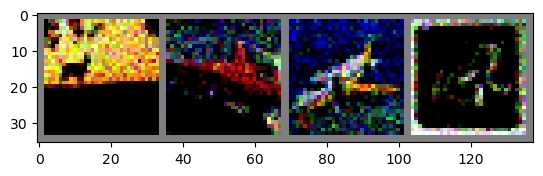

Truth:  deer  car   plane frog 


In [141]:
# Testing model on small batch

dataiter = iter(testloader)
images, labels = next(dataiter)

# show img from test set
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join(f'{testset.classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [143]:
# loading saved model
net = Net()
net.load_state_dict(torch.load('./Models/Full_Train_Gauss.pth'))

# Testing against above images
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{testset.classes[predicted[j]]:5s}'
                              for j in range(BATCH_SIZE)))

Predicted:  plane car   plane horse


In [134]:
# Testing model on entire test test
test_model(model_train_level_1, 'model_train_level_1', testloader, device)

Accuracy of the network on the 10000 test images: 48 %

Accuracy for class: plane is 10.0 %
Accuracy for class: car   is 90.0 %
Accuracy for class: bird  is 30.0 %
Accuracy for class: cat   is 40.0 %
Accuracy for class: deer  is 10.0 %
Accuracy for class: dog   is 70.0 %
Accuracy for class: frog  is 40.0 %
Accuracy for class: horse is 40.0 %
Accuracy for class: ship  is 90.0 %
Accuracy for class: truck is 63.6 %


In [139]:
PATH = './Models/Full_Train_Gauss.pth'
torch.save(model_train_level_1.state_dict(), PATH)